# Классификация
__Классификация__ - одна из самых важных форм предсказания: ее цель состоит в том, чтобы предсказать является ли запись 0 или 1 (купит/не купит, нажмет/не нажмет и пр.), либо в некоторых случаях одной из категорий (например,фильтрация входящих сообшений на почте - "основные", "спам", "соцсети" и т.д.). В случае, когда имеется более двух исходов, задачу часто можно преобразовать в серию двоичных задач с использованием условных вероятнстей. Например, по окончании действия договора, может быть 3 исхода:<br>
* $Y=0$ - клиент заключает новый долгосрочный договор<br>
* $Y=1$ - клиент переходит на оплату по месяцам<br>
* $Y=2$ - уходит к другому поставщику<br>

Т.е. чтобы решить исходную задачу, можно решить две двоичные (с двумя исходами) задачи:
1. Предсказать, $Y=0$ или $Y>0$
1. Если $Y>0, Y=1$ или $Y=2$

С точки зрения подгонки модели часто выгодно конвертировать многоклассовую задачу в серию двоичных задач. В особенности это актуально, когда одна категория распространена намного больше, чем другие категории.

### Наивный Байес
Наивный байесов алгоритм использует вероятность наблюдать значения предсказательных переменных при наличии некого исхода, чтобы оценить то, что по настоящему интересует: вероятность наблюдать исход $Y$ при наличии множества значений предсказателей.

__Полная (точная) байесовская классификация__.<br>
Для каждой классифицируемой записи:
1. Отыскать все другие записи с одинаковым предсказательным профилем (т.е. в которых значения предикторов одинаковы)
1. Определить к каким классам эти записи принадлежат и какой класс явл преобладающим (т.е. вероятным)
1. Назначить этот класс новой записи

`В стандартном байесовском подходе, все предикторы должны быть категориальными (факторными) переменными.` Точная байесовская классификация непрактична, т.к. если будет много предикторов, многие записи окажутся без точных совпадений.

### Наивное решение
В наивном решении, вычисление вероятности не ограничивается записями, которые совпадают с классифицируемой. Вместо этого используется весь набор данных.

* __Условная вероятность__ _(conditional probability)_ - вероятность наблюдать какое-то событие (скажем $X=i$) при условии, что имеется какое-то другое событие ($Y=i$); записывается как $P(X_i|Y_i)$.
* __Апостериорная вероятность__ _(posterior probability)_ - вероятность исхода после того, как предсказательная информация была учтена (в отличие от априорной вероятности исходов, которая ее не учитывает)
В наивном байесовом решении мы не ограничиваем вычисление вероятности теми записями, которые совпадают с классифицируемой. Вместо этого, используется весь набор данных:
1. Для двоичного отклика $Y=i$ ($i=0$ или $1$) оценить индивидуальные условные вероятности по каждому предсказателю $P(X_j|Y=i)$; они представляют собой вероятности того, что значение предсказателя находится в записи, когда мы наблюдаем $Y=i$. Указанная вероятность оценивается долей значений $X_j$ среди $Y=i$ записей в тренировочном наборе.
1. Перемножить эти вероятности друг с другом, а затем на долю записей, принадлежащих $Y=i$.
1. Повторить шаги 1 и 2 для всех классов.
1. Оценить вероятность для исхода __i__, взяв значение, вычисленное на шаге 2 для класса __i__ и поделив его на сумму таких значений для всех классов.
1. Отнести запись к классу с самой высокой вероятностью для этого множества значений предсказателй.

Вероятность наблюдать исход $Y=i$ при наличии множества значений предсказателей $X_1, ..., X_p$:

$$
P(Y=i|X_1, ..., X_p) = \frac{P(Y=i)P(X_1,...X_p|Y=i)}{P(Y=0)P(X_1,...,X_p|Y=0)+P(Y=1)P(X_1,...,X_p|Y=1)}
$$

в соответствии с наивным байесовским допущением об условной независимости это уравнение преобразуется в:

$$
P(Y=i|X_1, ..., X_p) = \frac{P(Y=i)P(X_1|Y=i)...P(X_p|Y=i)}{P(Y=0)P(X_1|Y=0)...P(X_p|Y=0)+P(Y=1)P(X_1|Y=1)...P(X_p|Y=1)}
$$

Эта формула называется "наивной", т.к. мы приняли упрощающее допущение, что _точная условная вероятность_ вектора значений предсказателей, при условии что наблюдается исход, достаточно хорошо оценивается произведением отдельных условных вероятностей $P(X_j|Y=i)$ и таким образом допускаем, что предсказательные переменные не зависят друг от друга. 

In [258]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Данные о заемах.

In [259]:
loan_data = pd.read_csv('/Users/ivankudravcev/Studying/Data/loan_data.csv.gz')
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [260]:
loan_data.dtypes

Unnamed: 0             int64
status                object
loan_amnt              int64
term                  object
annual_inc             int64
dti                  float64
payment_inc_ratio    float64
revol_bal              int64
revol_util           float64
purpose               object
home_ownership        object
delinq_2yrs_zero       int64
pub_rec_zero           int64
open_acc               int64
grade                float64
outcome               object
emp_length             int64
purpose_              object
home_                 object
emp_len_              object
borrower_score       float64
dtype: object

Для получения модели в Python можно воспользоваться классом `sklearn.naive_bayes.MultinomialNB` из пакета `scikit-learn`. Прежде чем выполнить подгонку модели, нам нужно конвертировать категориальные признаки в фиктивные переменные при помощи метода `pd.get_dummies()`. В качестве предсказываемой переменной будет `outcome`, которая может принять значения:
* default - означает не выплату
* paid off - означает что заем выплачен  

Условные вероятности из подогнанной модели можно получить при помощи функции `feature_log_prob_`.

In [273]:
# Преобразуем данные в категориальные
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True) # alpha - параметр сглаживания; 
                                                        # fit_propr-нужно ли изучать априорные вероятности класса или нет. 
naive_model.fit(X, y)

# Используем последнее значение данных для тестирования
new_loan = X.loc[146:146,:]
print(f'predicted class: {naive_model.predict(new_loan)[0]}')

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                            columns=naive_model.classes_)

print(probabilities)

conditional_probabilities = naive_model.feature_log_prob_ # условные вероятности

predicted class: default
    default  paid off
0  0.653696  0.346304


Полученная модель на примере последней записи предсказала исход: __default__, а также при помощи метода `predict_proba` получены вероятности классов. Наивный байесов классификатор известен тем, что он производит _смещенные_ оценки. Однако там, где целью является ранжирование записей согласно вероятности, что $Y=1$, несмещенные оценки вероятности не нужны, и наивный байесов классификатор производит хорошие результаты.

### Числовые предсказательные переменные
Байесов наивный классификатор работает только с категориальными предсказателями (например, с классификацией спама, где присутствие или отсутствие слов, фраз, символов и т.д. лежат в основе предсказательной задачи). Для применения наивного байесовского классификатора к числовым предсказателям д. б. принят один из 2 подходов:
* разложить на корзины и конвертировать числовые предсказатели в категориальные предсказатели и далее применить предыдущий алгоритм.
* использовать вероятностную модель - например, нормальное распределение - для оценки условной вероятности $P(X_j|Y=i)$.

### Дискриминантный анализ
Это самыё ранний статистический классификатор; он был представлен Фишером в 1936г. Охватывает несколько технических приемов, но самое широкое распространение получил _линейный дискриминантный анализ_ (Linear Discriminant Analysis, LDA). Сегодня LDA используется менее широко с появлениям древесных моделей и логистической регрессии. Однако, его можно встретить в некоторых приложениях и он имеет связи с другими более широко используемыми методами (например, анализ главных компонент). 
Не путать с латентным размещением Дирихле (Latent Dirichlet Allocation, LDA).

__Ковариация__ _(covariance)_ - мера степени, с которой переменная варьируется совместно с другой (т.е. с похожей магнитудой и направлением).
__Дискриминантная функция__ _(discriminant function)_ - функция, которая при ее применении к предсказателям максимизирует разделение классов.
__Дискриминантные веса__ _(discriminant weights)_ - баллы, получаемые в результате применения дискриминантной функции, которые используются для исчисления вероятностей принадлежности к тому или иному классу.


### Матрица ковариаций
Ковариация измеряет связь между двумя или несколькими переменными.

Ковариация $S_{x,z}$ между __x__ и __z__:
$$
S_{x,z} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(z_i-\bar{z})}{n-1}
$$
__n__ - число записей

Как и с корреляцией положительные значения говорят о положительной связи, а отрицательные об отрицательной. Коррелияция ограничена значениями -1:1, тогда как Ковариация находится на той же шкале измерения, что и переменные __x__ и __z__.

__Матрица ковариаций__ состоит из дисперсий индивидуальных переменных $S_x^2$ и $S^2_z$ на диагонали и ковариации между парами переменных вне диагоналей. Строки и столбцы - одинаковые переменные.

$$
\hat{\sum} = 
\begin{pmatrix}
S^2_x & S_{x,z}  \\
S_{x,z} & S^2_z 
\end{pmatrix}
$$

Стандартное отклонение применяется для нормализации переменной в z-оценку; матрица уовариаций используется в многомерном расширении этого процесса стандартизации. Оно известно как __расстояние Махаланобиса__ и связано с функцией линейного дискриминантного анализа.

### Линейный дискриминант Фишера
Предскажем довичный исход __y__, на основании двух непрерывных числовых переменных __(x, z)__. Линейный дискриминант Фишера различает вариацию _между_ группами, с одной стороны, и вариацию _внутри_ групп - с другой.  Стремясь разделить записи на две группы, LDA фокусируется на максимизации отношения между суммой квадратов $SS_{между}$ (вариация между двумя группами) и суммой квадратов $SS_{внутри}$ (вариация внутри группы). 

В этом случае две группы соответствуют записям:
* ($x_0, z_0$) для $y=0$
* ($x_1, z_1$) для $y=1$

Указанный метод отыскивает линейную комбинацию:
$$
w_xx+w_zz
$$

которая максимизирует отношение сумм квдартатов
$$
\frac{SS_{между}}{SS_{внутри}}
$$

__Межгрупповая сумма квадратов__ - квадратичное расстояние между двумя групповыми средними.

__Внутригрупповая сумма квадратов__  - разброс вокруг средних внутри каждой группы, взвешенный на матрицу ковариаций.

### Простой пример
Следующий фрагмент кода печататет оценочные веса линейного дискриминатора, используя 2 предиктора: балл заемщика 
`borrower_score` и отношение платежа к доходу `payment_inc_ratio`. Используется класс `LinearDiscriminantAnalysis` из модуля `sklearn.discriminant_analysis`. Свойство `scalings` дает оценочные веса.

In [262]:
loan3000 = pd.read_csv('loan3000.csv')

loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

pd.DataFrame(loan_lda.scalings_, index=X.columns, columns=['Weights'])

,Weights
borrower_score,7.175839
payment_inc_ratio,-0.099676


Метод `predict_proba` подогнанной модели возвращает вероятности для исходов __default__ (невыплата) и __paid off__ (погашено).

In [263]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                   columns = loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


График предсказаний (график оценочной вероятности) помогает проиллюстрировать то, как работает линейный дискриминантный анализ. Используя результат функции `predict`

   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio   default  
0            5.11135  0.553544  
1            5.43165  0.558953  
2            9.23003  0.272696  
3            2.33482  0.506254  
4           12.10320  0.609952  


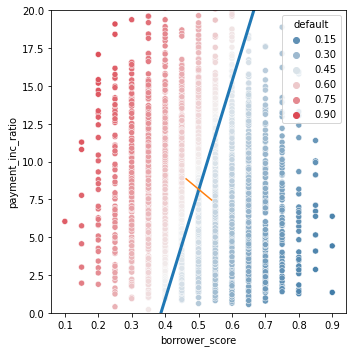

In [264]:
# Использовать scalings и центр средних для определения границы решения
center = np.mean(loan_lda.means_, axis=0) # центр
slope = -loan_lda.scalings_[0] / loan_lda.scalings_[1] # наклон
intercept = center[1] - center[0] * slope 

# Значение borrower_score при payment_inc_ratio равного 0 и 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
print(lda_df.head())

fig, ax = plt.subplots(figsize=(5, 5))
g = sns.scatterplot(x = 'borrower_score', y = 'payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=True)

ax.set_ylim(0,20)

ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()

__График оценочной вероятности__: точки данных слева от диагонали предсказываются как невыплата. Используя веса дискриминантной функции, линейный дискриминантный анализ разбивает предсказательное пространство на два участка. Предсказания, которые расположены дальше от линии (в обоих направлениях) имеют более высокий уровень доверия (т.е. вероятность намного дальше от 0.5)

__Линейный дискриминантный анализ__ работает также и более чем с 2 предикторами. Единственное ограничение - число записей (оценка матрицы ковариации требует достаточного числа записей на переменную, что в типичной ситуации не представляет проблему в приложениях науки о данных). Существуют и другие варианты дискриминантного анализа - cамым известным явл. квадратичный дискриминантный анализ (Quadratic Discriminant Analysis, QDA), несмотря на название явл. линейной функцией. Разница состоит в том, что в LDA матрица ковариаций принимается одинаковой для двух групп, соответствующих $Y=0$ и $Y=1$. А в QDA допускается, что матрица ковариаций может быть разной для двух групп, на практике эта разница не явл. критически важной.

* Дискриминантный анализ работает с непрерывными или категориальными предсказателями.
* Используя матрицу ковариаций, LDA вычисляет линейную дискриминантную функцию, которая используется для классификации записей.
* Эта функция применяется к записям для вычисления весов, или баллов, для каждой записи (один вес для каждого возможного класса), которые определяют к какому классу относится запись.

# Логистическая регрессия
Логистическая регрессия аналогична множественной линейной регрессии за одним исключением - исход явл. двоичным.

* __Логит (logit)__ - функция, которая отображает вероятность принадлежности классу в интервале $\pm\infty$ (вместо интервала от 0 до 1). 
* __Перевесы (odds)__ - отношение "успеха" (1) к "неуспеху" (0). Синонимы: шансы, фора, гандикап, преимущество.
* __Логарифм перевесов (log odds)__ - отклик в преобразованной модели (теперь линейный), котор. отображается назад в вероятность.

### Функция логистического отклика и логит
Ключевыми компонентами логистической регрессии явл. _функция логистического отклика_ и логит, в которых вероятность, находящаяся на шкале 0-1 отображается в вероятность на шкале $\pm\infty$, подходящую для линейного моделирования.

Первый шаг - думать о переменной исхода не как о двочиной метке, а как о вероятности _p_ того, что метка равна __1__. Может возникнуть соблазн наивно смоделировать _p_ как линейную функцию предсказательных переменных:

$$
    p=\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q
$$

Однако подгонка этой модели не обеспечит того, чтобы _p_ в итоге оказалась между 0 и 1, где должна быть вероятность.
Вместо этого, мы моделируем _p_ путем применения _логистического отклика_ или _обратного логита_ к предсказателям:

$$
    p=\frac{1}{1+e^{-(\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q)}}
$$

Указанное преобразование обеспечивает попадание вероятности в интервал 0-1. Для того чтобы извлечь экспоненциальное выражение из знаменателя, мы рассматриваем _шансы_(перевесы) вместо вероятностей.

__Шанс (odd)__ - вероятность события деленная на вероятность того что собтие не произойдет.

$$
    Шансы(Y=1)=\frac{p}{1-p}
$$

Можно расчитать вероятность из шансов:

$$
    p=\frac{Шансы}{1+Шансы}
$$

Комбинируя эту формулу с функцией логистического отклика, получаем:

$$
    Шансы(Y=1)=e^{\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q}
$$

Взяв логарифм выражений слева и справа от знака равенства, получается выражение, которое включает линейную функцию предсказателей:

$$
    log(Шансы(Y=1))=\beta_0+\beta_1x_1+\beta_2x_2+ ... + \beta_qx_q
$$

Функция _логарифма шансов_ (логит функция) отображает вероятность _p_ из интервала (0, 1) в любое значение из интервала $\pm\infty$. Цикл преобразования завершен; была использована линейная модель для предскзаания вероятности, которую, в свою очередь, можно отобразить на метку класса путем применения правила отсечения - любая запись с вероятностью, превышающей порог отсечения, классифицируется как 1.

      p     logit      odds
0  0.01 -4.595120  0.010101
1  0.02 -3.891820  0.020408
2  0.03 -3.476099  0.030928
3  0.04 -3.178054  0.041667
4  0.05 -2.944439  0.052632


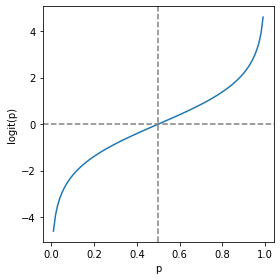

In [265]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p':p,
    'logit': np.log(p / (1-p)),
    'odds': p / (1-p)
})
print(df.head())
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(df['p'], df['logit'])
ax.axvline(0.5, color='grey', ls='--')
ax.axhline(0, color='grey', ls='--')

ax.set_xlabel('p')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()


График логит-функции, которая отображает вероятность в шкалу, подходящую для линейной модели.

### Логистическая регрессия и ОЛМ (обобщенные линейные модели)
Отклик в формуле логистической регресссии - это логарифм перевесов двоичного исхода 1. Мы наблюдаем только двоичный исход, а не логарифм перевесов, и поэтому для подгонки уравнения требуются специальные статистические методы. 

Логистическая регрессия явл. частным случаем _обобщенной линейной модели_ (generalized linear model, GLM), разработанной для расширения линейной регрессии.
Следующий фрагемнт кода выполняет подгонку логистической регрессии к данным о персональных ссудах. 

В _Python_ мы используем класс `LogosticRegression` из модуля `sklearn.linear_model`. Аргументы `penalty` и `С` применяются для предотвращения переподгонки регуляризацией __L1__ и __L2__. Регуляризация включена по умолчанию. Для того, чтобы выполнить переподгонку без регуляризации, мы устанавливаем `С` равным очень большому значению. Аргумент `solver` выбирает используемый минимизатор; по умолчанию  используется метод 'lbfgs'.

In [349]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 
              'emp_len_', 'borrower_score']
outcome = 'outcome'


X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                  drop_first=True)
y = loan_data['outcome']


logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print(f'Intercept: {logit_reg.intercept_[0]}')
print(f'classes: {logit_reg.classes_}')
pd.DataFrame({'coeff':logit_reg.coef_[0]}, index=X.columns)

Intercept: -1.6378908649112442
classes: ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


Пересчение и большинство коэффициентов отрицательны и если поменять порядок вывода классов переменной отклика Y ('default' и 'paid off'), который в _Python_ осуществляется в алфафитном порядке, __мы получим неинвертированные значения__.
Если есть "фича" или переменная отклика c порядковыми значениями, можно использовать метод `OrdinalEncoder` из пакета _scikit-learn_ для того чтобы заменить категории (здесь 'default' и 'paid off') на соответствующие числовые значения. В следующем коде происходит замена значения 'paid off' на 0 и 'default' на 1. Таким образом изменяется порядок вывода классов и как следствие коэффициенты будут обратными:

In [350]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print(f'Intercept: {logit_reg_enc.intercept_[0]}')
print(f'outpt classes: {logit_reg_enc.classes_}')
print('Predictor classes:')
print(f"purpose_: {[i for i in loan_data['purpose_'].cat.categories]}")
print(f"home_: {[i for i in loan_data['home_'].cat.categories]}")
print(f"emp_len_: {[i for i in loan_data['emp_len_'].cat.categories]}")
pd.DataFrame({'coeff':logit_reg_enc.coef_[0]}, index=X.columns)

Intercept: 1.6380885430318344
outpt classes: [0. 1.]
Predictor classes:
purpose_: ['credit_card', 'debt_consolidation', 'home_improvement', 'major_purchase', 'medical', 'other', 'small_business']
home_: ['MORTGAGE', 'OWN', 'RENT']
emp_len_: [' < 1 Year', ' > 1 Year']


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


__Полученные коэффициенты являются относительными. Т.е. для переменной `purpose_` все значения коэффициентов расчитаны
относительно значения `credit_card` и т.д.__

### Обобщенные линейные модели
Обобщенные линейные модели (ОЛМ, Generalized Linear Model, GLM) характеризуется двумя главными компонентами:
* вероятностным распределением или семейством (биномиальным в случае логистической регрессии)
* функцией связи, т.е. функцией преобразования, которая отображает отклик в предсказатели (логит в случае логистической регрессии)

Логистическая регрессия, безусловно, является наиболее часто встречающейся формой ОЛМ. Исследователь данных будет сталкиваться и с другими ОЛМ. Иногда вместо логита используется логарифм функции связи; на практике применение логарифма функции связи вряд ли приведет к сильно отличающимся результатам для большинства приложений.

### Предсказанные значения из логистической регрессии.
Предсказанное значение из логистической регрессии, рассматривается с точки зрения логарифма перевесов:
$$
 \hat{Y}=log(Шансы(Y=1))
$$
Предсказанная вероятность задается функцией логистического отклика:
$$
 \hat{p}=\frac{1}{1+e^{-\hat{Y}}}
$$
Посмотрим на предсказанные значения из модели _logit_reg_. В _Python_ мы можем конвертировать вероятности в _dataframe_ и использовать метод _decribe()_, чтобы получить характеристики распределения:

In [351]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                   columns=loan_data[outcome].cat.categories)

pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,-0.757872,-0.760434
std,0.378093,0.390456
min,-2.769376,-3.538593
25%,-0.985739,-0.977207
50%,-0.697406,-0.688907
75%,-0.472183,-0.467069
max,-0.029485,-0.064753


Вероятности можно вычислить при помощи метода `predict_proba()` пакета _scikit-learn_:

In [352]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                   columns=loan_data['outcome'].cat.categories)
pred

,default,paid off
0,0.242505,0.757495
1,0.314114,0.685886
2,0.516650,0.483350
3,0.588009,0.411991
4,0.458639,0.541361
...,...,...
45337,0.547161,0.452839
45338,0.462878,0.537122
45339,0.447686,0.552314
45340,0.278304,0.721696


Эти значения вероятности находятся на шкале от 0 до 1 и еще не объявляют о том, имеет ли предсказание значение "default" или "paid off"

### Интерперетирование коэффициентов и отношений перевесов
Преимущество логистической регрессии состоит в том, что она порождает модель, которую ускоренно можно применять для задания баллов новым данным без повторного вычисления. Еще одно преимущество - относительная простота интерпретации модели по сравнению с другими классификационными методами. Ключевая идея заключается в понимании _отношения перевесов_, или _шансов_. Отношение перевесов легче всего понять для двоичной факторной переменной X:
$$
отношение-перевесов = \frac{Шансы(Y=1|X=1)}{Шансы(Y=1)|(X=0)}
$$
Указанная формула интерпретируется как шансы того, что Y=1, когда X=1, против шансов того, что Y=1, когда X=0. Если отношение перевесов равно 2, то шансы того, что Y=1, будут в два раза выше, когда X=1, чем когда X=0.

Мы работаем с шансами (вместо вероятностей) потому что коэффициент $\beta_j$ в логистической регрессии явл. логарифмом отношения щансов для $X_j$.
Пример: для ранее подогнанной модели `logit_reg_enc`, коэффициент регрессии для переменной `purpose_small_business` равен 1.215662. Он означает, что заём малому бизнесу в сравнении с заёмом для погашения кредитной карты, уменьшает шансы невыплаты ('default') против шансов погашения ('paid off') на exp(1.215662) = 3.4. Безусловно, кредиты в целях создания или расширения малого бизнеса значительно рискованнее других типов кредитов.

Ниже приведен код, который строит график который отражает связь между _отношением щансов_ и _отношением лоагрифма шансов_ для _отношения перевесов_ > 1. Поскольку коэффициенты находятся на логарифмической шкале, увеличение на 1 в коэффициентах приводит к увеличению на exp(1)=2.72 в _отношении шансов_

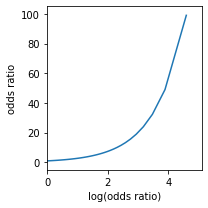

In [353]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5,105)

plt.tight_layout()
plt.show()

Отношения перевесов для числовых переменных X можно проинтерпретировать схожим образом: они измеряют изменение в отношении перевесов для единичного изменения в X. Например, эффект увеличения отношения платежей к доходам, скажем с 5 до 6 увеличивает перевес невыплаты ('default') заёма в exp(0.079728) = 1.08 раз. Переменная `borrower_score` - это балл кредитоспособности заемщиков от 0 (низкий) до 1 (высокий). Перевес лучших заемщиков относительно худших, которые не возвращают ссуды, меньше в exp(-4.611037) = 0.01 раз. Другими словами, риск невыплаты от заемщиклв с самой слабой кредитоспособностью в 100 раз больше, чем риск невыплаты у самых лучших заемщиков!

### Линейная и логистическая регрессия: 
### сходства и различия
Имеют много схожиж черт: обе принимают параметрическую линейную форму, увязывающую предсказатели с откликом. Разведывание и отыскание лучшей модели выполняется очень похоже. Расширения линейной модели, такие как сплайновые преобразования предикторов одинаковым образом применимы в логистической регрессионной формулировке.
Однако, есть 2 фундаментальных отличия:
* характер выполнения подгонки модели (наименьшие квадраты не применимы)
* природа и анализ остатков модели.

#### Подгонка модели
Подгонка линейной регрессии осуществляется за счет метода наименьших квадратов, а качество подгонки оценивается при помощи метрик RMSE и $R^2$.
В логистической регрессии (в отличие от линейной) подгонка модели осуществляется методом _оценки максимального правдоподобия_ (Maximum Liklihood Estimation, MLE).  Оценка максимального правдоподобия - это процедура, пытающаяся отыскать модель, вероятнее всего породившую данные, которые мы видим. В уравнении логистической регрессии откликом явл. не 0 или 1, а оценка логарифма перевесов о том, что отклик равняется 1. Оценка максимального правдоподобия отыскивает такое решение, что оценочный логарифм перевесов наилучшим образом описывает наблюдаемый исход. 

#### Работа с факторными переменными
В логистической регрессии факторные переменные также должны кодироваться в числовые значения как и в линейной регрессии.

#### Оценка результаттивности модели
Как и другие классификационные методы, логистическая регрессия оценивается тем, насколько точно модель классифицирует новые данные. Как и в случае с линейной регрессией, имеется несколько стандартных статистических инструментов. Пакет `statsmodels` имеет имплементацию для обобщенной линейной модели (GLM), которая сообщает стандартной ошибке коэффициентов, z-оценке и p-значении.
Для сравнения, здесь создается модель GLM с использованием statsmodels. Этот метод требует, чтобы результат (переменная отклика) сопоставлялся с числами.

In [357]:
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1),
                     family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Thu, 09 Jun 2022   Deviance:                       57515.
Time:                        19:35:53   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0